# Titanic dataset solution

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Reading data

In [2]:
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

## EDA

In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


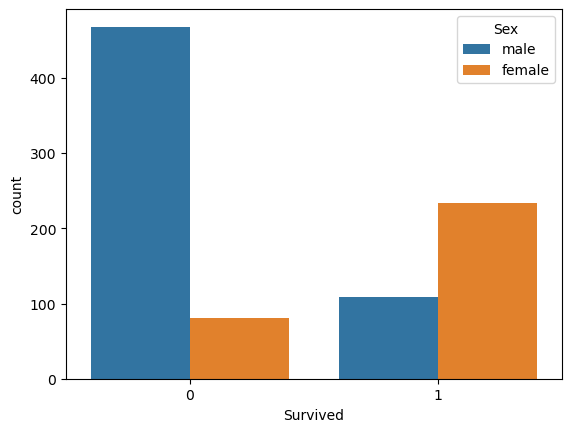

In [6]:
sns.countplot(data=train, x='Survived', hue='Sex')
plt.show()

### NA handling

Let's see which columns have missing values

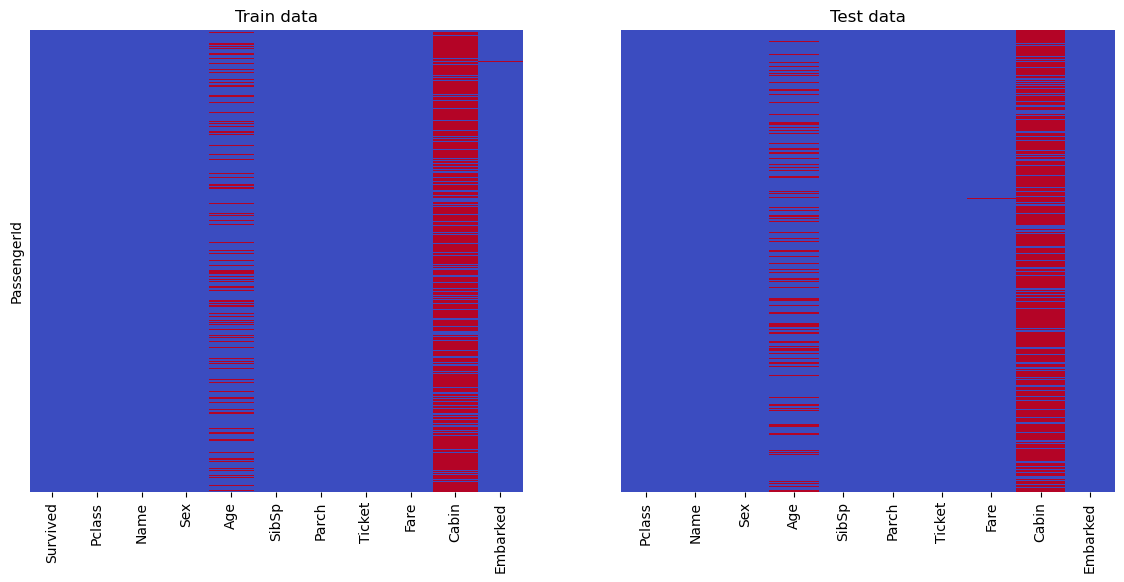

In [7]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train.isnull(), cmap='coolwarm', yticklabels=False, cbar=False)
plt.title('Train data')

plt.subplot(1, 2, 2)
sns.heatmap(test.isnull(), cmap='coolwarm', yticklabels=False, cbar=False)
plt.title('Test data')
plt.ylabel('')
plt.show()

Looks like both train and test data has a lot of missing values in Age and Cabin features

#### Cabin feature

Let's see how much of Cabin feature is missing

In [8]:
print(f"Missing values in train data: {100*train['Cabin'].isna().sum()/len(train):.1f}%")
print(f"Missing values in test data: {100*test['Cabin'].isna().sum()/len(test):.1f}%")

Missing values in train data: 77.1%
Missing values in test data: 78.2%


There is a lot of missing data so we drop that feature

In [9]:
train.drop(labels='Cabin', axis=1, inplace=True)
test.drop(labels='Cabin', axis=1, inplace=True)

#### Age feature

Let's see if there is correlation between Age and other features

In order to see in correlation matrix Embarked feature we should make it numerical. So we're using label encoding to add temp column

In [10]:
train['Embarked_tmp'], _ = pd.factorize(train['Embarked'])

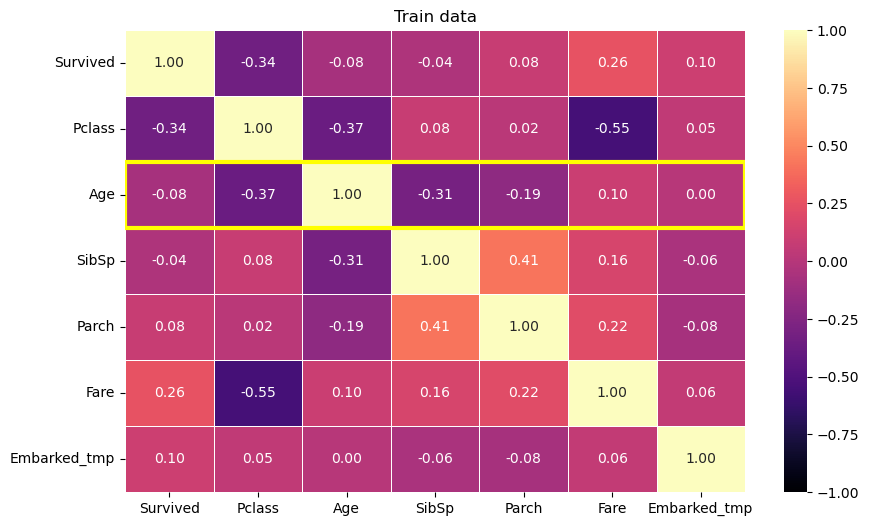

In [11]:
train_corr = train.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(train_corr, annot=True, vmin=-1, vmax=1, linewidths=0.5, fmt='.2f', cmap='magma')
plt.gca().add_patch(plt.Rectangle((0, train_corr.index.get_loc('Age')), train_corr.shape[1], 1, fill=False, edgecolor='yellow', lw=3))
plt.title('Train data')

plt.show()

Looks like Age has negative correlation with Pclass

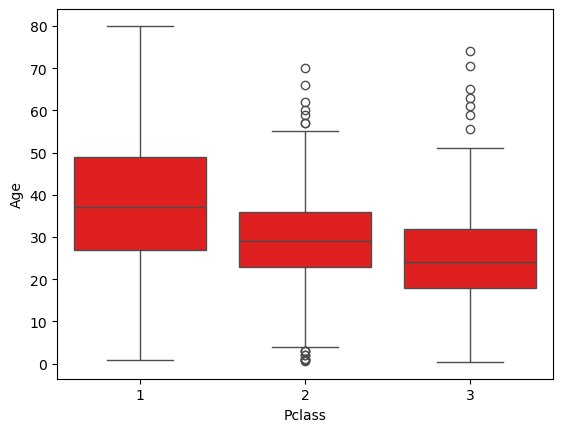

In [12]:
sns.boxplot(data=train, x='Pclass', y='Age', color='r')
plt.show()

Actually it makes sense, older people are likely to be more wealthy and can afford a better class

Let's fill NA values in Age depending on Pclass feature

In [13]:
def fill_missing_age(cols):
    age, pclass = cols.loc['Age'], cols.loc['Pclass']
    if pd.isnull(age):
        age = train[train['Pclass'] == pclass]['Age'].median()
    return age

In [14]:
train['Age'] = train[['Age', 'Pclass']].apply(fill_missing_age, axis=1)

In [15]:
test['Age'] = test[['Age', 'Pclass']].apply(fill_missing_age, axis=1)

#### Embarked feature

Embarked feature is not correlated with any other feature so we fill NA with most frequent value

In [16]:
train['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [17]:
train['Embarked'] = train['Embarked'].fillna('S')
train.drop('Embarked_tmp', axis=1, inplace=True)

#### Fare feature

Fare is also correlated with Pclass

In [18]:
def fill_missing_fare(cols):
    age, pclass = cols.loc['Fare'], cols.loc['Pclass']
    if pd.isnull(age):
        age = train[train['Pclass'] == pclass]['Fare'].median()
    return age

In [19]:
test['Fare'] = test[['Fare', 'Pclass']].apply(fill_missing_fare, axis=1)

Let's check that all datasets don't have any missing values

In [20]:
train.isna().any()

Survived    False
Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Ticket      False
Fare        False
Embarked    False
dtype: bool

In [21]:
test.isna().any()

Pclass      False
Name        False
Sex         False
Age         False
SibSp       False
Parch       False
Ticket      False
Fare        False
Embarked    False
dtype: bool

All the missing values filled!

## Encoding categorical features

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


Let's see how much categorical features we have

In [62]:
train.select_dtypes('object').columns.tolist()

['Name', 'Sex', 'Ticket', 'Embarked']

Assuming Name and Ticket have no impact on wether person survived or not, we will encode only Sex and Embarked features

In [63]:
features = ['Sex', 'Embarked']
train = pd.get_dummies(data=train, columns=features, drop_first=True)
test = pd.get_dummies(data=test, columns=features, drop_first=True)

## Feature engineering

Adding new feature FamilySize

In [64]:
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
test['FamilySize'] = test['Parch'] + test['SibSp'] + 1

## Splitting data

In [65]:
X_train = train.drop(labels=['Survived', 'Name', 'Ticket'], axis=1)
y_train = train['Survived'].copy()
X_test = test.drop(labels=['Name', 'Ticket'], axis=1)

## Data Scaling

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

Importing models

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

### Finding Hyperparameters

Let's define models and their hyperparameters

In [68]:
models = {
    'ElasticNet': LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga'),
    'Lasso': LogisticRegression(max_iter=1000, penalty='l1'),
    'Ridge': LogisticRegression(max_iter=1000, penalty='l2'),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier()
}

In [69]:
params = {
    'ElasticNet': {
        'C': [0.01, 0.02, 0.03, 0.04, 0.05],
        'l1_ratio': [0, 0.01, 0.03, 0.06, 0.1, 0.15, 0.2]
    },
    'Lasso': {
        'C': [0.8, 1, 1.5, 2, 3],
        'solver': ['liblinear', 'saga']
    },
    'Ridge': {
        'C': [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10],
        'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 250, 500, 750, 1000, 2000],
        'max_depth': [2, 5, 8, 12, 15, None],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [1, 2],
    },
    'XGBClassifier': {
        'n_estimators': [400, 500, 600, 700, 800],
        'max_depth': [6, 7, 8, 9, 10],
        'learning_rate': [0.005, 0.008, 0.01, 0.02, 0.03],
        'min_child_weight': [1, 2, 4],
        'subsample': [0.9, 1],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0, 1, 2],
        'reg_alpha': [0, 0.01, 0.03, 0.1],
        'reg_lambda': [1, 3, 5]
    },
}

Fitting the models

In [70]:
import time

kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_params = {}

for model_name, model in models.items():
    grid = GridSearchCV(estimator=model, param_grid=params[model_name], cv=kf, scoring='accuracy', n_jobs=-1, verbose=2)
    grid.fit(X_train, y_train)
    best_params[model_name] = grid.best_params_
    print('Best parameters:', grid.best_params_)
    print('Best score:', grid.best_score_)
    time.sleep(1)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best parameters: {'C': 0.02, 'l1_ratio': 0.06}
Best score: 0.8092272926997678
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'C': 2, 'solver': 'liblinear'}
Best score: 0.8058313979034587
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'C': 0.01, 'solver': 'lbfgs'}
Best score: 0.8069738246186681
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
Best score: 0.8372606867114432
Fitting 5 folds for each of 81000 candidates, totalling 405000 fits
Best parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.008, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1}
Best score: 0.8518548741447493


In [71]:
import json

with open('best_params.json', 'w', encoding='utf-8') as file:
    json.dump(best_params, file, indent=4)

### Stacking the models

Let's stack models and predict y_test

In [34]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('ElasticNet', LogisticRegression(max_iter=1000, penalty='elasticnet', solver='saga', C=0.03, l1_ratio=0)),
    ('Lasso', LogisticRegression(max_iter=1000, penalty='l1', C=1, solver='saga')),
    ('Ridge', LogisticRegression(max_iter=1000, penalty='l2', C=0.03, solver='lbfgs')),
    ('RandomForestClassifier', RandomForestClassifier(**best_params['RandomForestClassifier'])),
    ('XGBClassifier', XGBClassifier(**best_params['XGBClassifier']))
]

stack = StackingClassifier(estimators=estimators, cv=kf)

stack.fit(X_train, y_train)

pred = stack.predict(X_test)

Creating submission file

In [76]:
predictions = pd.DataFrame(data=pred, index=test.index, columns=['Survived'])
predictions.to_csv('submition.csv', encoding='utf-8')